In [2]:
import os
!gdown 1-1iPIpGC8ghlPUsotJmgKjUgs91ZqEyR

Downloading...
From (original): https://drive.google.com/uc?id=1-1iPIpGC8ghlPUsotJmgKjUgs91ZqEyR
From (redirected): https://drive.google.com/uc?id=1-1iPIpGC8ghlPUsotJmgKjUgs91ZqEyR&confirm=t&uuid=ca6b7916-d0b6-4596-82d3-31b69d3976d8
To: /content/dataA_upsampled.pt
100% 384M/384M [00:04<00:00, 83.4MB/s]


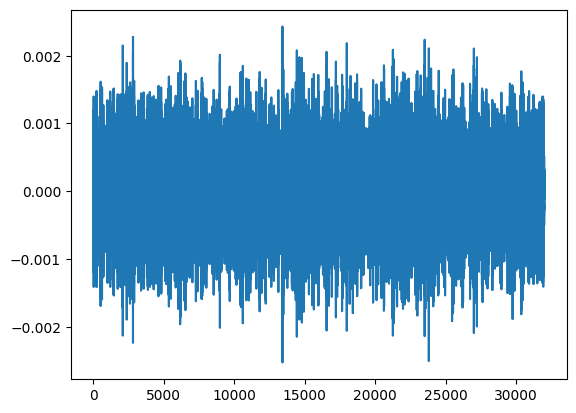

torch.Size([1, 32000])


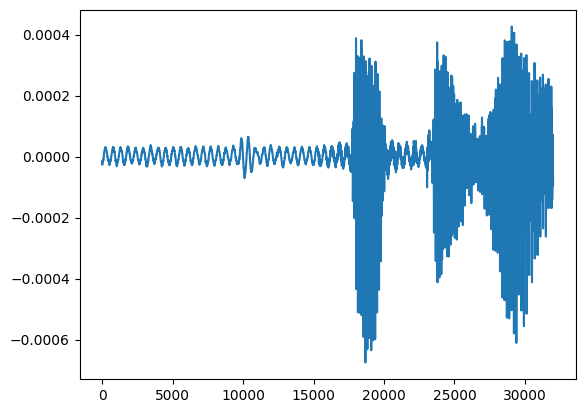

torch.Size([1, 32000])


In [3]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio,display
import numpy as np

dataset_name='dataA_upsampled.pt'
#dataset_name='data_lab2A_upsampled.pt'

# This line sets up your notebook to use a GPU if it is available.
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")
dataA = torch.load(dataset_name,map_location=device)

# Dataset parameters. Change if you use a different dataset
sample_rate = 32000
seconds_per_clip = 1
num_samples = sample_rate * seconds_per_clip

# Data consist of a list of 1500 (x,y) tuples.

# Take one sample and separate x and y
data_0 = dataA[0]
x_0 = data_0[0].cpu()
y_0 = data_0[1].cpu()

# Noisy signal plot and play
plt.plot(x_0[0])
plt.show()
display(Audio(x_0[0],rate=sample_rate))
print(x_0.shape)

# Original signal plot and play
plt.plot(y_0[0])
plt.show()
display(Audio(y_0,rate=sample_rate))
print(y_0.shape)

In [4]:
# Split into train and test
test_size = 100
train_size = len(dataA) - test_size

# Use a Pytorch utility to split into train and test randomly. Before we were doing this manually on the tensors.
train_set_FCNN, test_set_FCNN =  torch.utils.data.random_split(dataA, [train_size, test_size])

In [5]:
import torch.nn as nn
import torch.functional as F

# define Neural network class as in lab 1
class FCNN(nn.Module):
    def __init__(self, n_input, hidden_size=100):
        super().__init__()
        # This is a two layer neural network, with input size equal to output size because
        # want to generate a signal of the same dimensions.
        self.linear1 = nn.Linear(n_input, hidden_size, bias=True)
        self.linear2 = nn.Linear(hidden_size, n_input, bias=True)


    def forward(self, x):
        x = self.linear1(x)
        x = nn.functional.relu(x)
        x = self.linear2(x)
        return x


def evaluate(dataloader, estimator):
    '''
    This function performs evaluation (Computing MSE) using a dataloader and an estimator (an instance of a Pytorch model).
    '''
    mse = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            yHat = estimator.forward(x_batch)
            mse += torch.mean((yHat-y_batch)**2)
    numBatchs = len(dataloader)
    mse /= numBatchs
    return mse.item()

epoch 1 / 30. Loss 0.0033023732248693705
epoch 2 / 30. Loss 0.003302321070805192
epoch 3 / 30. Loss 0.003302267985418439
epoch 4 / 30. Loss 0.0033022158313542604
epoch 5 / 30. Loss 0.003302162978798151
epoch 6 / 30. Loss 0.003302110591903329
epoch 7 / 30. Loss 0.0033020577393472195
epoch 8 / 30. Loss 0.003302005585283041
epoch 9 / 30. Loss 0.0033019527327269316
epoch 10 / 30. Loss 0.003301900113001466
epoch 11 / 30. Loss 0.0033018477261066437
epoch 12 / 30. Loss 0.0033017953392118216
epoch 13 / 30. Loss 0.0033017427194863558
epoch 14 / 30. Loss 0.0033016898669302464
epoch 15 / 30. Loss 0.003301637712866068
epoch 16 / 30. Loss 0.0033015853259712458
epoch 17 / 30. Loss 0.0033015324734151363
epoch 18 / 30. Loss 0.0033014798536896706
epoch 19 / 30. Loss 0.003301427699625492
epoch 20 / 30. Loss 0.0033013748470693827
epoch 21 / 30. Loss 0.003301322693005204
epoch 22 / 30. Loss 0.003301270306110382
epoch 23 / 30. Loss 0.00330121791921556
epoch 24 / 30. Loss 0.0033011657651513815
epoch 25 / 30

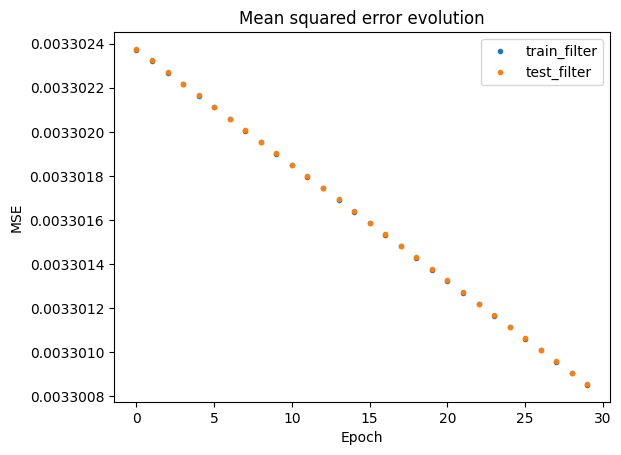

In [6]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create an estimator using the FCNN class and send it to our device (CPU or GPU)
estimator = FCNN(num_samples).to(device)

# Parameters for training
lr=0.01
batch_size = 128


# Optimizer and loss function.
optimizer = optim.SGD(estimator.parameters(), lr=lr)
loss_L1 = nn.MSELoss()


# Instantiate Data Loaders
train_loader_FCNN = DataLoader(
    train_set_FCNN,
    batch_size=batch_size,
    shuffle=True,
)

test_loader_FCNN = DataLoader(
    test_set_FCNN,
    batch_size=batch_size,
    shuffle=False,
)

mse_evolution = []
mse_evolution_test = []


# Training loop

n_epochs = 30
# Iterate n_epochs times over the whole dataset.

for ep in range(n_epochs):
    #iterate over all batches in the dataset
    for x_batch, y_batch in train_loader_FCNN:
        # Sends the current batch's data to the GPU (or do nothing if working with CPU)
        x_batch=x_batch.to(device)
        y_batch=y_batch.to(device)
        # set gradients to zero
        estimator.zero_grad()

        # Compute predictions
        yHat = estimator.forward(x_batch)

        # Compute error
        #mse = torch.mean((yHat-y_batch)**2)
        mse = loss_L1(yHat,y_batch)
        mse.backward()


        # Update parameters
        optimizer.step()

    # Evaluate on training data at the end of the epoch
    epoch_mse_filter = evaluate(train_loader_FCNN, estimator)
    mse_evolution.append(epoch_mse_filter)

    # Evaluate on test data at the end of the epoch
    mseTest_filter = evaluate(test_loader_FCNN, estimator)
    mse_evolution_test.append(mseTest_filter)
    print(f'epoch {ep+1} / {n_epochs}. Loss {epoch_mse_filter}')

# Plot results
_ = plt.plot(mse_evolution, ".", label="train_filter")
_ = plt.title("Mean squared error evolution")
_ = plt.xlabel("Epoch")
_ = plt.ylabel("MSE")
_ = plt.plot(mse_evolution_test, ".", label="test_filter")
_ = plt.legend()



In [7]:
# Listen to the samples

# (change to try other audios)
nmbr_example = 7


sample_x, sample_y =dataA[nmbr_example]
predicted_y = estimator(sample_x.reshape([1,1,-1]))[0].detach()

print(f'Original Audio')
display(Audio(sample_y.cpu(), rate=sample_rate))

print(f'Noisy Audio')
display(Audio(sample_x.cpu(), rate=sample_rate))

print(f'Audio recovered with filter')
display(Audio(predicted_y.cpu(), rate=sample_rate))

Original Audio


Noisy Audio


Audio recovered with filter


In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.functional as F

# Define the convolutional function
def convolution_1D(signal,filter,device=device):
    """
    This function performs a convolution with the given filter.
    """
    # Get the number of taps from the shape ofthe filter
    taps = filter.shape[-1]

    # Instantiate the accumulated results from the convolution.
    z = torch.zeros(signal.shape).to(device)
    for k in range(taps):
        # Add the results for the current tap
        z = z + signal * filter[k]
        # Rolls the tensor one positions (see pytorch docs for more details)
        signal = signal.roll(1)
        # Set the signal at the first position to zero
        signal[:,0] = 0
    return z

# Define the convolutional class
class ConvolutionalLayer(nn.Module):
    def __init__(self,taps):
        super().__init__()
        self.filter = torch.nn.Parameter(torch.ones(taps))

    def forward(self,x):
        # Use the convolution_1D function we defined above, and pass in our filter taps.
        return convolution_1D(x,self.filter)

In [9]:
# Split data into train and test. We have 100 test examples.
test_size = 100
train_size = len(dataA) - test_size

train_set_filter, test_set_filter =  torch.utils.data.random_split(dataA, [train_size, test_size])

In [10]:
# Same training loop as before, but using a "ConvolutionalLayer" model as as an estimator.
estimator = ConvolutionalLayer(taps = 10).to(device)

lr=0.005
batch_size = 16

optimizer = optim.SGD(estimator.parameters(), lr=lr)
loss_L2 = nn.MSELoss(reduction='sum')


# Instantiate Data Loaders
train_loader_CL = DataLoader(
    train_set_filter,
    batch_size=batch_size,
    shuffle=True,
)

test_loader_CL = DataLoader(
    test_set_filter,
    batch_size=batch_size,
    shuffle=False,
)

mse_evolution_test = []
mse_evolution = []


# Training loop

n_epochs = 20
# Iterate n_epochs times over the whole dataset.
estimator.train()

for ep in range(n_epochs):
    #iterate over all batches in the dataset
    estimator.train()
    for x_batch, y_batch in train_loader_CL:
        # Sends the current batch's data to the GPU (or do nothing if working with CPU)
        x_batch=x_batch.to(device)
        y_batch=y_batch.to(device)
        # set gradients to zero
        estimator.zero_grad()

        # Compute predictions
        yHat = estimator.forward(x_batch)

        # Compute error
        mse = loss_L2(yHat,y_batch)

        mse.backward()

        # Update parameters
        optimizer.step()

    # Evaluate on training data at the end of the epoch
    epoch_mse_filter = evaluate(train_loader_CL, estimator)
    mse_evolution.append(epoch_mse_filter)

    # Evaluate on test data at the end of the epoch

    mseTest_filter = evaluate(test_loader_CL, estimator)
    mse_evolution_test.append(mseTest_filter)
    print(f'epoch {ep+1} / {n_epochs}; loss: {mseTest_filter}',end='\r')
print(mse_evolution_test)

[2.89878926196252e-07, 2.240588230506546e-07, 1.7743862201768934e-07, 1.444094408498131e-07, 1.2103440383270936e-07, 1.0449610243767893e-07, 9.279813184548402e-08, 8.453802280428135e-08, 7.870308849078356e-08, 7.459004791599e-08, 7.169003168883137e-08, 6.965316146079203e-08, 6.822288867169846e-08, 6.721999312730986e-08, 6.65201369542956e-08, 6.603281832440189e-08, 6.569351995722172e-08, 6.54590905924124e-08, 6.52981739790448e-08, 6.518814643641235e-08]


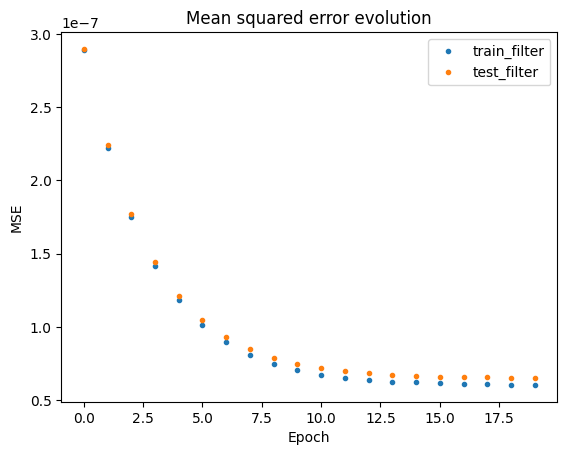

In [11]:
# Plot results
_ = plt.plot(mse_evolution, ".", label="train_filter")
_ = plt.title("Mean squared error evolution")
_ = plt.xlabel("Epoch")
_ = plt.ylabel("MSE")
_ = plt.plot(mse_evolution_test, ".", label="test_filter")
_ = plt.legend()

In [12]:
# Listen to the samples

# (change to try other audios)
nmbr_example = 5

x_batch, y_batch = next(iter(test_loader_CL))
sample_x, sample_y = x_batch[nmbr_example], y_batch[nmbr_example]
predicted_y = estimator(sample_x).detach()[0]

print(f'Original Audio')
display(Audio(sample_y.cpu(), rate=sample_rate))

print(f'Noisy Audio')
display(Audio(sample_x.cpu(), rate=sample_rate))

print(f'Audio recovered with filter')
display(Audio(predicted_y.cpu(), rate=sample_rate))

Original Audio


Noisy Audio


Audio recovered with filter


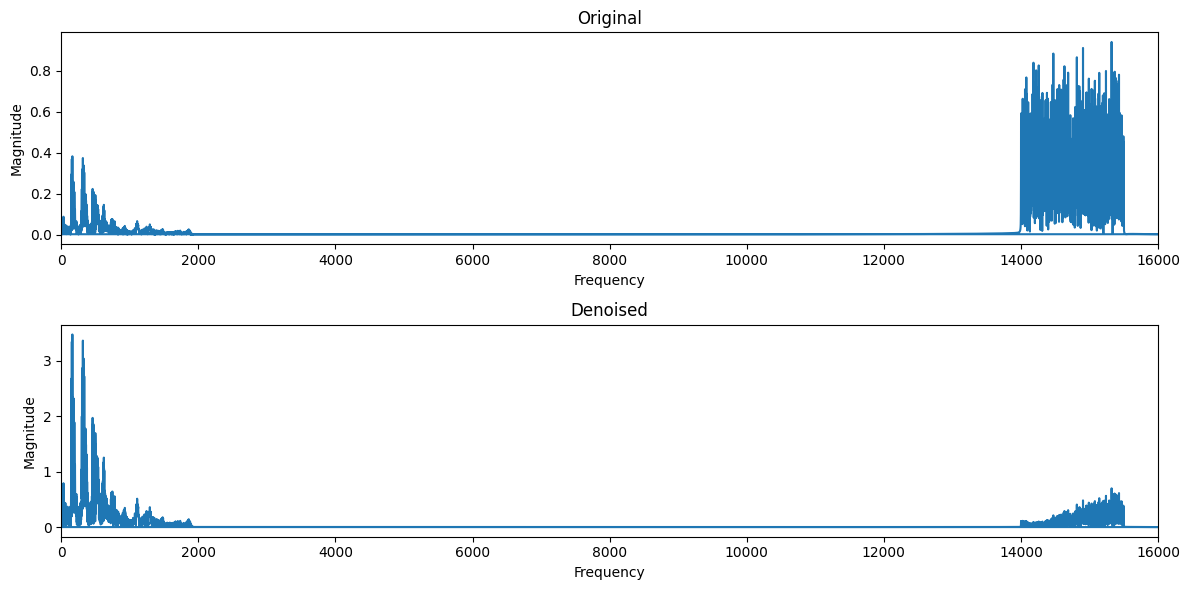

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

signal1 = sample_x.cpu()[0]
signal2 = predicted_y.cpu()

sample_rate=32000

# Compute the Fourier Transform
fft_signal1 = np.fft.fft(signal1)
fft_signal2 = np.fft.fft(signal2)

# Compute the frequency axis
N = len(signal1)
freq = np.fft.fftfreq(N, d=1/sample_rate)

# Plot the magnitude spectrum of the Fourier Transform for both signals
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(freq, np.abs(fft_signal1))
plt.title('Original')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0, sample_rate / 2)  # Limiting x-axis to half the sampling rate (Nyquist frequency)

plt.subplot(2, 1, 2)
plt.plot(freq, np.abs(fft_signal2))
plt.title('Denoised')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.xlim(0, sample_rate / 2)  # Limiting x-axis to half the sampling rate (Nyquist frequency)

plt.tight_layout()
plt.show()

display(Audio(signal1,rate=sample_rate))
display(Audio(signal2,rate=sample_rate))